In [1]:
## data
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from unicodedata import normalize

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# contagem de aging
from collections import Counter

from IPython.display import display, HTML

## modelo
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# check xgboost version
from xgboost import XGBClassifier

## alertas
import warnings
warnings.filterwarnings("ignore")

***
## Coleta de dados

In [2]:
FILE = "/kaggle/input/datasetsnew/batdtfim500kage.csv"
dados = pd.read_csv(FILE, sep = ';', encoding = 'ISO-8859-1', engine ='python')

dados = dados.rename(columns={'a.msisdn': 'msisdn'})\
             .rename(columns={'a.imsi': 'imsi'})\
             .rename(columns={'a.tac': 'tac'})\
             .rename(columns={'a.dt_inicio': 'dt_inicio'})\
             .rename(columns={'a.dt_fim': 'dt_fim'})\
             .rename(columns={'a.aging_aparelho': 'aging_aparelho'})\
             .rename(columns={'a.cat_aparelho': 'cat_aparelho'})\
             .rename(columns={'a.trocou_aparelho': 'trocou_aparelho'})\
             .rename(columns={'a.fabricante': 'fabricante'})\
             .rename(columns={'a.modelo': 'modelo'})\
             .rename(columns={'a.imei': 'imei'})\
             .rename(columns={'a.ranking': 'ranking'})\
             .rename(columns={'a.cpfidentifier': 'cpfidentifier'})\
             .rename(columns={'a.subscriberkey': 'subscriberkey'})\
             .rename(columns={'a.customerkey': 'customerkey'})\
             .rename(columns={'a.customersubtypedesc': 'customersubtypedesc'})\
             .rename(columns={'a.subscriberstatuskey': 'subscriberstatuskey'})\
             .rename(columns={'a.offertechnology': 'offertechnology'})\
             .rename(columns={'a.citydesc': 'citydesc'})\
             .rename(columns={'a.statedesc': 'statedesc'})\
             .rename(columns={'a.subscribermainofferdesc': 'subscribermainofferdesc'})\
             .rename(columns={'a.assignedchargeamount': 'assignedchargeamount'})\
             .rename(columns={'a.fl_3g': 'fl_3g'})\
             .rename(columns={'a.fl_4g': 'fl_4g'})\
             .rename(columns={'a.fl_5g': 'fl_5g'})\
             .rename(columns={'a.dt_ano_stts': 'dt_ano_stts'})\
             .rename(columns={'a.idade': 'idade'}).drop_duplicates().reset_index(drop=True)

dados

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,offertechnology,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
0,5532998068556,724235404829984,35415808,2021-02-17,2022-04-09,13,1,1,SAMSUNG,GALAXY J7 PRIME (SM-G610M DS),...,PostPaid,NaN,MINAS GERAIS,LINHA ADICIONAL VIVO FAMÃLIA 150GB,0.00,0.0,1.0,0.0,2016.0,31
1,5521988674638,724112005547717,35690411,2021-05-29,NaN,16,1,0,"Motorola Mobility LLC, a Lenovo Company",ODESSA20,...,Controle,NaN,RIO DE JANEIRO,VIVO CTRL DIGITAL_11GB ILIM_,67.14,0.0,1.0,0.0,2020.0,83
2,5555999595054,724065007509989,35175119,2021-03-31,NaN,18,1,0,SAMSUNG,"GALAXY S21 PLUS 5G (SM-G996B,DS)",...,PostPaid,NaN,RIO GRANDE DO SUL,LINHA ADICIONAL VIVO FAMILIA 100GB,0.00,0.0,0.0,1.0,2020.0,56
3,5527997623734,724113001405241,35991710,2021-05-29,NaN,16,1,0,Multilaser Industrial S.A.,MULTILASER F PRO,...,Controle,NaN,ESPIRITO SANTO,VIVO CONTROLE DIG-7GB_,52.88,0.0,1.0,0.0,2019.0,65
4,5567996046665,724066795495313,35613011,2021-07-23,NaN,14,1,0,SAMSUNG,"GALAXY A01 (SM-A015M,DS)",...,Controle,NaN,MATO GROSSO DO SUL,VIVO CONTROLE 4GB IV,37.49,0.0,1.0,0.0,2020.0,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445614,5541992819276,724064006643479,35892323,2021-05-06,NaN,17,1,0,Samsung Korea,GALAXY A52 5G,...,PostPaid,NaN,PARANA,LINHA ADICIONAL VIVO FAMILIA 150GB,0.00,0.0,0.0,1.0,2020.0,63
445615,5511941319852,724102190782505,35092033,2021-03-25,NaN,18,1,0,"Motorola Mobility LLC, a Lenovo Company",GUAM+20,...,Controle,NaN,SAO PAULO,VIVO CONTROLE 7GB_,53.35,0.0,1.0,0.0,2020.0,50
445616,5518996551019,724101993846396,35690411,2021-09-03,NaN,13,1,0,"Motorola Mobility LLC, a Lenovo Company",ODESSA20,...,Controle,NaN,SAO PAULO,VIVO CONTROLE 4GB,37.61,0.0,1.0,0.0,2020.0,58
445617,5561982989551,724066490746154,35614110,2021-10-15,NaN,12,1,0,SAMSUNG,"GALAXY A30 (SM-A305GT,DS)",...,PostPaid,NaN,DISTRITO FEDERAL,TITULAR VIVO FAMILIA 60GB - MENSAL,234.99,0.0,1.0,0.0,2019.0,51


### Limpeza dos dados

In [3]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [4]:
just_check_nan(dados)

Dados com NaN:
dt_fim                     355669
citydesc                   445619
statedesc                      58
subscribermainofferdesc      3580
assignedchargeamount         3513
fl_3g                         100
fl_4g                         100
fl_5g                         100
dt_ano_stts                   100
dtype: int64

columns_with_nan.shape (9,)



In [5]:
dados_droped = dados.dropna(subset=['imsi',
                                    'statedesc', 
                                    'subscribermainofferdesc', 
                                    'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts'])\
                    .reset_index(drop=True)
# dados_droped

In [6]:
just_check_nan(dados_droped)

Dados com NaN:
dt_fim      352571
citydesc    441832
dtype: int64

columns_with_nan.shape (2,)



### Equilibrando classes

In [7]:
dados_droped_0 = dados_droped[dados_droped['trocou_aparelho'] == 0].sample(frac=0.53, random_state=3)
dados_droped_1 = dados_droped[dados_droped['trocou_aparelho'] == 1]

In [8]:
dados_droped = pd.concat([dados_droped_0, dados_droped_1]).reset_index(drop=True).sort_values(by='msisdn', ascending=False)
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,offertechnology,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
150919,5599999844114,724119896659201,35194123,2021-04-30,NaN,17,1,0,APPLE,IPHONE 11 (A2221),...,Controle,NaN,MARANHAO,VIVO CONTROLE 11GB - ANUAL,66.20,0.0,1.0,0.0,2020.0,52
183436,5599999778280,724119113878348,35768964,2021-05-17,2022-05-19,12,1,1,Samsung Korea,GALAXY NOTE20 ULTRA 5G,...,PostPaid,NaN,MARANHAO,TITULAR VIVO SELFIE - AMAZON PRIME - 20GB,109.99,0.0,0.0,1.0,2020.0,63
248651,5599999770208,724119112384725,35767712,2021-05-04,2022-05-17,12,1,1,APPLE,IPHONE 12 PRO MAX (A2411),...,PostPaid,NaN,MARANHAO,LINHA ADICIONAL VIVO V,0.00,0.0,0.0,1.0,2020.0,29
68982,5599999530131,724119114015020,35260709,2021-07-09,NaN,15,1,0,SAMSUNG,GALAXY J7 PRIME (SM-G610M DS),...,PostPaid,NaN,MARANHAO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2017.0,30
134256,5599999523030,724119805984364,35973519,2021-07-14,NaN,15,1,0,APPLE,IPHONE 12 PRO MAX (A2342),...,PostPaid,NaN,MARANHAO,TITULAR VIVO V,1299.99,0.0,0.0,1.0,2021.0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204607,5511910003326,724102090904887,35187408,2021-02-03,2022-05-02,14,1,1,"Motorola Mobility LLC, a Lenovo Company","MOTO G (4TH GEN), AF12788145",...,PostPaid,NaN,SAO PAULO,Titular INTERNET_MOVEL_100GB,112.30,0.0,1.0,0.0,2016.0,48
160708,5511910003293,724102007432614,35175910,2021-08-02,NaN,14,1,0,SAMSUNG,GALAXY J6 PLUS (SM-J610F),...,Controle,NaN,SAO PAULO,VIVO CONTROLE 11GB I,72.60,0.0,1.0,0.0,2018.0,42
164645,5511910001745,724102802140721,35188909,2021-09-21,NaN,12,1,0,MOTOROLA,MOTOROLA MOTO G5S (XT1792),...,PostPaid,NaN,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2017.0,36
215888,5511910001363,724102007216056,35470311,2021-02-19,2022-04-17,13,1,1,SAMSUNG,"GALAXY A71 (SM-A715F,DSM)",...,PostPaid,NaN,SAO PAULO,TITULAR VIVO FAMILIA 60GB,235.13,0.0,1.0,0.0,2019.0,60


In [9]:
# checando balanço das classes
y_trocou_aparelho = dados_droped['trocou_aparelho']

c_trocou_aparelho = Counter(y_trocou_aparelho)
c_trocou_aparelho

Counter({0: 182768, 1: 96987})

In [10]:
dados_droped = dados_droped.tail(dados_droped.shape[0] -70000).reset_index(drop=True)
dados_droped['dt_ano_stts'] = dados_droped['dt_ano_stts'].astype(np.int64).reset_index(drop=True)
# dados_droped2 = dados_droped[dados_droped['trocou_aparelho'] == 1].reset_index()
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,offertechnology,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
0,5561996483543,724066636897557,35920909,2021-02-05,2022-05-07,15,1,1,SAMSUNG,SM-J810M DS,...,Controle,NaN,DISTRITO FEDERAL,VIVO CONTROLE 8GB II,55.99,0.0,1.0,0.0,2018,43
1,5561996480791,724066792261505,35749808,2021-03-21,2022-04-09,12,1,1,SAMSUNG,GALAXY S8 PLUS (SM-G955U1),...,PostPaid,NaN,DISTRITO FEDERAL,Linha Adicional Vivo PÃ³s FamÃ­lia 300GB,0.00,0.0,1.0,0.0,2017,62
2,5561996480665,724066005975248,35176011,2021-06-14,NaN,16,1,0,SAMSUNG,"GALAXY A30S (SM-A307GT,DS)",...,Controle,NaN,DISTRITO FEDERAL,VIVO CONTROLE 5GB IV,41.99,0.0,1.0,0.0,2019,58
3,5561996479991,724066612267664,86936704,2020-12-18,2022-05-11,16,1,1,XIAOMI,REDMI NOTE 8 (M1908C3JG),...,Controle,NaN,GOIAS,VIVO CONTROLE 7GB_,37.40,0.0,1.0,0.0,2019,53
4,5561996479968,724066613400511,35365512,2021-04-03,NaN,18,1,0,SAMSUNG,SGH-C110,...,Controle,NaN,GOIAS,VIVO CONTROLE 11GB - ANUAL,70.72,0.0,1.0,0.0,2020,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209750,5511910003326,724102090904887,35187408,2021-02-03,2022-05-02,14,1,1,"Motorola Mobility LLC, a Lenovo Company","MOTO G (4TH GEN), AF12788145",...,PostPaid,NaN,SAO PAULO,Titular INTERNET_MOVEL_100GB,112.30,0.0,1.0,0.0,2016,48
209751,5511910003293,724102007432614,35175910,2021-08-02,NaN,14,1,0,SAMSUNG,GALAXY J6 PLUS (SM-J610F),...,Controle,NaN,SAO PAULO,VIVO CONTROLE 11GB I,72.60,0.0,1.0,0.0,2018,42
209752,5511910001745,724102802140721,35188909,2021-09-21,NaN,12,1,0,MOTOROLA,MOTOROLA MOTO G5S (XT1792),...,PostPaid,NaN,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2017,36
209753,5511910001363,724102007216056,35470311,2021-02-19,2022-04-17,13,1,1,SAMSUNG,"GALAXY A71 (SM-A715F,DSM)",...,PostPaid,NaN,SAO PAULO,TITULAR VIVO FAMILIA 60GB,235.13,0.0,1.0,0.0,2019,60


In [11]:
dados_droped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209755 entries, 0 to 209754
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   msisdn                   209755 non-null  int64  
 1   imsi                     209755 non-null  int64  
 2   tac                      209755 non-null  int64  
 3   dt_inicio                209755 non-null  object 
 4   dt_fim                   65191 non-null   object 
 5   aging_aparelho           209755 non-null  int64  
 6   cat_aparelho             209755 non-null  int64  
 7   trocou_aparelho          209755 non-null  int64  
 8   fabricante               209755 non-null  object 
 9   modelo                   209755 non-null  object 
 10  imei                     209755 non-null  object 
 11  ranking                  209755 non-null  int64  
 12  cpfidentifier            209755 non-null  int64  
 13  subscriberkey            209755 non-null  int64  
 14  cust

***
### Analise individual

In [12]:
dados_droped['cat_aparelho'].unique()

array([1])

In [13]:
dados_droped['trocou_aparelho'].unique()

array([1, 0])

In [14]:
dados_droped['aging_aparelho'].unique()

array([15, 12, 16, 18, 14, 13, 17])

In [15]:
dados_droped['customersubtypedesc'].unique()

array(['Pessoa FÃ\xadsica'], dtype=object)

In [16]:
dados_droped['subscriberstatuskey'].unique()

array(['A'], dtype=object)

In [17]:
dados_droped['ranking'].unique()

array([1, 2])

In [18]:
# dados_droped['assignedchargeamount'].unique()

In [19]:
dados_droped['fl_3g'].equals(dados_droped['fl_4g'])

False

In [20]:
dados_droped['fl_3g'].equals(dados_droped['fl_5g'])

False

In [21]:
dados_droped['fl_4g'].equals(dados_droped['fl_5g'])

False

In [22]:
dados_droped['trocou_aparelho'].unique()

array([1, 0])

In [23]:
dados_droped['idade'].unique()

array([ 43,  62,  58,  53,  38,  34,  45,  40,  31,  28,  52,  42,  32,
        24,  64,  41,  55,  50,  60,  39,  46,  37,  44,  49,  47,  19,
        61,  85,  63,  78,  79,  33,  73,  48,  25,  70,  51,  54,  35,
        66,  36,  69,  56,  82,  71,  59,  23,  65,  21,  67,  68,  20,
        18,  30,  57,  27,  29,  22,  74,  75,  26,  77,  76,  93,  84,
        72,  91,  90,  87,  83,  81,  80,  86,  92,  88, 122,  94,  89,
        98,  16,  95,   1, 102,  13,   2,   9,  96, 251,   3, 144,  17,
         4, 111, 269,   0, 103,  97, 150, 146,  12, 101])

***
## Exploração dos dados

### seleção de features

In [24]:
# define features
X_ta = dados_droped[['fabricante', 'modelo', 'ranking', 'aging_aparelho', 
                     'offertechnology', 
                     'statedesc', 'subscribermainofferdesc', 'assignedchargeamount', 
                     'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade']]
X_ta

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
0,SAMSUNG,SM-J810M DS,1,15,Controle,DISTRITO FEDERAL,VIVO CONTROLE 8GB II,55.99,0.0,1.0,0.0,2018,43
1,SAMSUNG,GALAXY S8 PLUS (SM-G955U1),1,12,PostPaid,DISTRITO FEDERAL,Linha Adicional Vivo PÃ³s FamÃ­lia 300GB,0.00,0.0,1.0,0.0,2017,62
2,SAMSUNG,"GALAXY A30S (SM-A307GT,DS)",1,16,Controle,DISTRITO FEDERAL,VIVO CONTROLE 5GB IV,41.99,0.0,1.0,0.0,2019,58
3,XIAOMI,REDMI NOTE 8 (M1908C3JG),1,16,Controle,GOIAS,VIVO CONTROLE 7GB_,37.40,0.0,1.0,0.0,2019,53
4,SAMSUNG,SGH-C110,1,18,Controle,GOIAS,VIVO CONTROLE 11GB - ANUAL,70.72,0.0,1.0,0.0,2020,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209750,"Motorola Mobility LLC, a Lenovo Company","MOTO G (4TH GEN), AF12788145",1,14,PostPaid,SAO PAULO,Titular INTERNET_MOVEL_100GB,112.30,0.0,1.0,0.0,2016,48
209751,SAMSUNG,GALAXY J6 PLUS (SM-J610F),1,14,Controle,SAO PAULO,VIVO CONTROLE 11GB I,72.60,0.0,1.0,0.0,2018,42
209752,MOTOROLA,MOTOROLA MOTO G5S (XT1792),1,12,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2017,36
209753,SAMSUNG,"GALAXY A71 (SM-A715F,DSM)",1,13,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 60GB,235.13,0.0,1.0,0.0,2019,60


In [25]:
X_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209755 entries, 0 to 209754
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   fabricante               209755 non-null  object 
 1   modelo                   209755 non-null  object 
 2   ranking                  209755 non-null  int64  
 3   aging_aparelho           209755 non-null  int64  
 4   offertechnology          209755 non-null  object 
 5   statedesc                209755 non-null  object 
 6   subscribermainofferdesc  209755 non-null  object 
 7   assignedchargeamount     209755 non-null  float64
 8   fl_3g                    209755 non-null  float64
 9   fl_4g                    209755 non-null  float64
 10  fl_5g                    209755 non-null  float64
 11  dt_ano_stts              209755 non-null  int64  
 12  idade                    209755 non-null  int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 20.8+ MB


#### Variaveis Categoricas

In [26]:
# Get list of categorical variables
s_ta = (X_ta.dtypes == 'object')
object_cols_ta = list(s_ta[s_ta].index)
print("Categorical variables: ", len(object_cols_ta))
print(object_cols_ta)

Categorical variables:  5
['fabricante', 'modelo', 'offertechnology', 'statedesc', 'subscribermainofferdesc']


#### Variaveis Numéricas

In [27]:
# Criando uma lista de variaveis numéricas
numerical_cols_ta = [cname for cname in X_ta.columns if X_ta[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols_ta))
print(numerical_cols_ta)

Numerical variables:  8
['ranking', 'aging_aparelho', 'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade']


***
## Mostrando a correlação entre os dados numéricos

In [28]:
corr_trocou_aparelho = dados_droped[['fabricante', 'modelo',
                                     'ranking', 'aging_aparelho',
                                     'offertechnology', 
                                     'statedesc', 'subscribermainofferdesc',
                                     'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                                     'dt_ano_stts', 'idade', 'trocou_aparelho']]

<AxesSubplot:>

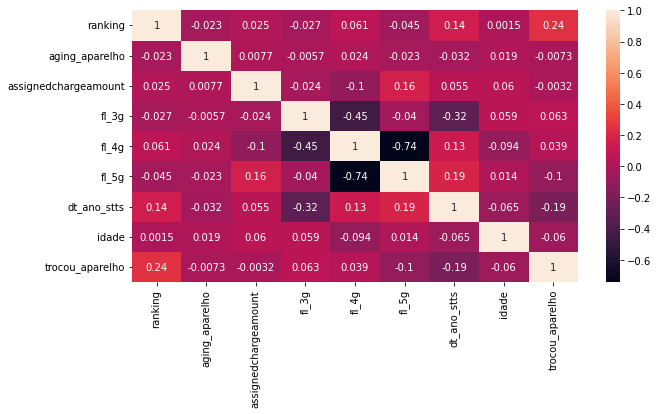

In [29]:
corr = corr_trocou_aparelho.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True)

In [30]:
dados_droped['mes_jan'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-01') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-01')

dados_droped['mes_fev'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-02') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-02')

dados_droped['mes_mar'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-03') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-03')

dados_droped['mes_abr'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-04') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-04')

dados_droped['mes_mai'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-05') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-05')

dados_droped['mes_jun'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-06') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-06')

dados_droped['mes_jul'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-07') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-07')  
                                                
dados_droped['mes_ago'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-08') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-08')

dados_droped['mes_set'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-09') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-09')

dados_droped['mes_out'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-10') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-10')

dados_droped['mes_nov'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-11') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-11')

dados_droped['mes_dez'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-12') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-12')

In [31]:
corr_meses_troca = dados_droped[['mes_jan', 'mes_fev', 'mes_mar', 'mes_abr', 
                                 'mes_mai', 'mes_jun', 'mes_jul', 'mes_ago', 
                                 'mes_set', 'mes_out', 'mes_nov', 'mes_dez', 'trocou_aparelho']]

<AxesSubplot:>

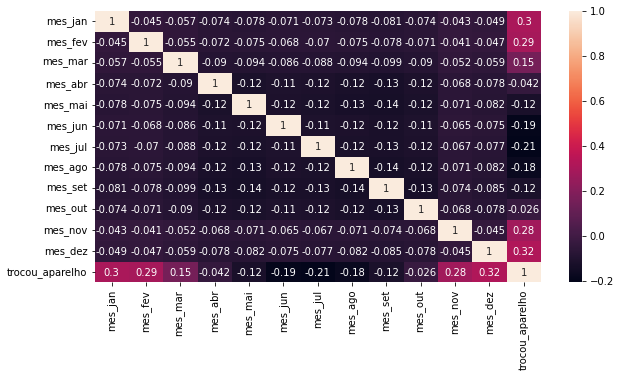

In [32]:
corr_Test = corr_meses_troca.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr_Test, xticklabels = corr_Test.columns, yticklabels = corr_Test.columns, annot = True)

***
***
***
## Definição do Target trocou_aparelho

In [33]:
def plot_feature_freq(df, feature, qt_cat):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)

    # ordena pelas mais frequentes
    order = np.argsort(counts)[::-1]
    labels, counts = labels[order], counts[order]

    g = sns.barplot(labels[:qt_cat], counts[:qt_cat])
    g.set_xticklabels(labels[:qt_cat], rotation=90)
    
    return g

In [34]:
# define target
y_trocou_aparelho = dados_droped['trocou_aparelho']

c_trocou_aparelho = Counter(y_trocou_aparelho)
c_trocou_aparelho

Counter({1: 71249, 0: 138506})

<AxesSubplot:>

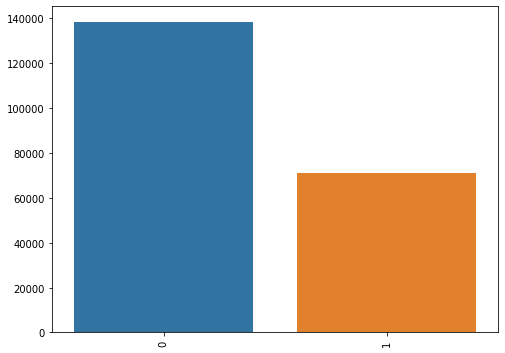

In [35]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho', len(dados_droped['trocou_aparelho'].unique()))

***
## Modelagem trocou_aparelho

In [36]:
# # calculo da proporção da base
# estimate = c_trocou_aparelho[0] / c_trocou_aparelho[1]
# estimate

In [37]:
# Dividindo as features em dados de treino e teste
X_train_ta, X_val_ta, y_train_ta, y_val_ta = train_test_split(X_ta, 
                                                              y_trocou_aparelho, 
                                                              test_size=0.5, 
                                                              random_state = 2048)

# Pré-processamento para Dados Numéricos
numerical_transformer_ta = Pipeline([
                                     ('scaler', StandardScaler())
                                    ])

# Pré-processamento para Dados Categóricos
categorical_transformer_ta = Pipeline([
                                       ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
                                      ])

# Pré-processamento de pacote de dados numéricos e categóricos
preprocessor_ta = ColumnTransformer(transformers=[
                                                  ('num', numerical_transformer_ta, numerical_cols_ta),
                                                  ('cat', categorical_transformer_ta, object_cols_ta)
                                                 ], n_jobs=-1)

pipeline_ta = Pipeline(steps=[
                              ('preprocessor', preprocessor_ta),
                              ('smote', SMOTE(random_state=42, n_jobs=-1)),
                              ('model', GradientBoostingClassifier(random_state=2048))
                             ])

# Preprocessing of training data, fit model 
pipeline_ta.fit(X_train_ta, y_train_ta)

# Predictions
# preds = np.asarray(pipeline.predict(X_val), dtype = 'int')
preds_ta = pipeline_ta.predict(X_val_ta)

In [38]:
c_train_ta = Counter(y_train_ta)
c_train_ta


Counter({1: 35732, 0: 69145})

In [45]:
c_val_ta = Counter(y_val_ta)
c_val_ta


Counter({0: 69361, 1: 35517})

In [44]:
c_preds_ta = Counter(preds_ta)
c_preds_ta

Counter({1: 49071, 0: 55807})

***
## Métricas

In [ ]:
print(classification_report(y_val_ta, preds_ta))

In [ ]:
cm_df_ta = pd.DataFrame(confusion_matrix(y_val_ta, preds_ta),
                     index = sorted(Counter(y_val_ta)),
                     columns = sorted(Counter(preds_ta)))
cm_df_ta

In [ ]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline_ta,
        X_val_ta,
        y_val_ta,
        display_labels=['Não Trocou', 'Trocou'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

## Captação dos clientes que foram previstos como Propensos a Fazer uma Compra

In [ ]:
X_val_ta['trocou_aparelho'] = y_val_ta
# X_val_ta

In [ ]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho', len(X_val_ta['trocou_aparelho'].unique()))

In [ ]:
X_val_ta['trocou_aparelho_previsto'] = preds_ta
# X_val_ta

In [ ]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho_previsto', len(X_val_ta['trocou_aparelho_previsto'].unique()))

In [ ]:
X_val_ta['cpfidentifier'] = dados_droped['cpfidentifier']
# X_val_ta

In [ ]:
X_val_ta['dt_inicio'] = dados_droped['dt_inicio']
# X_val_ta

In [ ]:
X_val_ta['dt_fim'] = dados_droped['dt_fim']
X_val_ta

***
***
***
## Separando as bases para outro modelo

In [ ]:
base_to_pred_month = X_val_ta[X_val_ta['trocou_aparelho_previsto'] == 1].reset_index(drop=True)
base_to_pred_month

***
***
***
## Definição do Target aging_aparelho

In [ ]:
# define target
y = base_to_pred_month['aging_aparelho']

In [ ]:
# contagem de aging
from collections import Counter

c = Counter(y)
c

In [ ]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(base_to_pred_month, 'aging_aparelho', len(base_to_pred_month['aging_aparelho'].unique()))

### Definicão das features

In [ ]:
# define features
X = base_to_pred_month[['fabricante', 'modelo',
                        'ranking',
                        'offertechnology', 
                        'statedesc', 'subscribermainofferdesc',
                        'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                        'dt_ano_stts', 'idade']]
X

#### Variaveis Categoricas

In [ ]:
# Get list of categorical variables
s = (X.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables: ", len(object_cols))
print(object_cols)

#### Variaveis Numéricas

In [ ]:
# Criando uma lista de variaveis numéricas
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols))
print(numerical_cols)

***
## Mostrando a correlação entre os dados numéricos

In [ ]:
corr_mes_previsao = base_to_pred_month[['fabricante', 'modelo',
                                        'ranking',
                                        'offertechnology', 
                                        'statedesc', 'subscribermainofferdesc',
                                        'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                                        'dt_ano_stts', 'idade', 'aging_aparelho']]

In [ ]:
corr2 = corr_mes_previsao.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr2, xticklabels = corr2.columns, yticklabels = corr2.columns, annot = True)

***
## Modelagem

In [ ]:
# Dividindo as features em dados de treino e teste - 70% para dados de treinamento e 30% para dados de teste
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.5, 
                                                  random_state = 2048)

# Pré-processamento para Dados Numéricos
numerical_transformer = Pipeline([
                                  ('scaler', StandardScaler())
                                 ])

# Pré-processamento para Dados Categóricos
categorical_transformer = Pipeline([
                                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
                                   ])

# Pré-processamento de pacote de dados numéricos e categóricos
preprocessor = ColumnTransformer(transformers=[
                                                ('num', numerical_transformer, numerical_cols),
                                                ('cat', categorical_transformer, object_cols)
                                              ], n_jobs=-1)

pipeline = Pipeline(steps=[
                            ('preprocessor', preprocessor),
#                             ('smote', SMOTE(random_state=42, n_jobs=-1)),
                            ('model', RandomForestClassifier(random_state=2048))
#                             ('model', GradientBoostingClassifier(random_state=2048))
#                             ('model', XGBClassifier(scale_pos_weight=estimate, random_state=2048))
                          ])

# Preprocessing of training data, fit model 
pipeline.fit(X_train, y_train)

# Predictions
#preds = np.asarray(pipeline.predict(X_val), dtype = 'int')
preds = pipeline.predict(X_val)

In [ ]:
c_train = Counter(y_train)
c_train

In [ ]:
c_val = Counter(y_val)
c_val

In [ ]:
c_preds = Counter(preds)
c_preds

In [ ]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(base_to_pred_month, 'aging_aparelho', len(base_to_pred_month['aging_aparelho'].unique()))

***
## Métricas

In [ ]:
print(classification_report(y_val, preds))

In [ ]:
cm_df = pd.DataFrame(confusion_matrix(y_val, preds),
                     index = sorted(Counter(y_val)),
                     columns = sorted(Counter(preds)))
cm_df

## Plot non-normalized confusion matrix

In [ ]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X_val,
        y_val,
        display_labels=['12', '13', '14', '15', '16', '17', '18'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

***
## Mesclando resultados com tabela

### Com a base de validação

In [ ]:
X_val['aging_aparelho'] = y_val
# X_val

In [ ]:
X_val['previsto'] = preds
# X_val

In [ ]:
X_val['cpfidentifier'] = base_to_pred_month['cpfidentifier']
# X_val

In [ ]:
X_val['dt_inicio'] = base_to_pred_month['dt_inicio']
# X_val

In [ ]:
X_val['dt_fim'] = base_to_pred_month['dt_fim']
# X_val

## Calculando data prevista

In [ ]:
X_val['dt_fim_previsto'] = ((pd.to_datetime(X_val['dt_inicio']).dt.to_period('M')) + X_val['previsto'])
X_val

In [ ]:
c_preds

In [ ]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val, 'aging_aparelho', len(X_val['aging_aparelho'].unique()))

In [ ]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val, 'previsto', len(X_val['previsto'].unique()))